# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 04 Spectral subtraction, Wiener filtering, end point detectoin, voice activity detection
2023/04/07

----
### import packages, define analysis parameters and draw parameters, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

---
### load speech and noise

오디오 파일들의 경로 정의

In [5]:
audioinputpath = '../audio'
outpath = 'out'

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

다음의 두 개의 파일을 이용하여 speech 와 noise의 특성을 비교하여 본다.

In [6]:
speechfile = addpath(audioinputpath, 'gjang-kdigits0-3.wav')
noisefile  = addpath(audioinputpath, 'car.wav')

__load files in windows wav format__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [7]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speechfile, speech.shape, speech)
print(noisefile, noise.shape, noise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/gjang-kdigits0-3.wav (37952,) [-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04]
../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  0.98169835, -48.88611563,   3.1324693 , ...,  -9.12823462,
          2.7801733 ,   1.09309141],
       [ 15.65259614,  16.00577403,  16.22904319, ...,  13.82631938,
         15.76671355,  17.55505021],
       [ 15.55749858,  17.52033179,  17.45295515, ...,  18.98548141,
         19.86723635,  19.6122841 ],
       ...,
       [-68.11610281, -60.06479629, -62.70839477, ..., -49.39283694,
        -45.83500294, -56.26431093],
       [-54.83801771, -52.36526795, -56.37173569, ..., -50.60357958,
        -46.87544314, -60.39318112],
       [-66.43200604, -53.80243152, -73.95182647, ..., -48.89061985,
        -46.85413105, -52.25941962]])

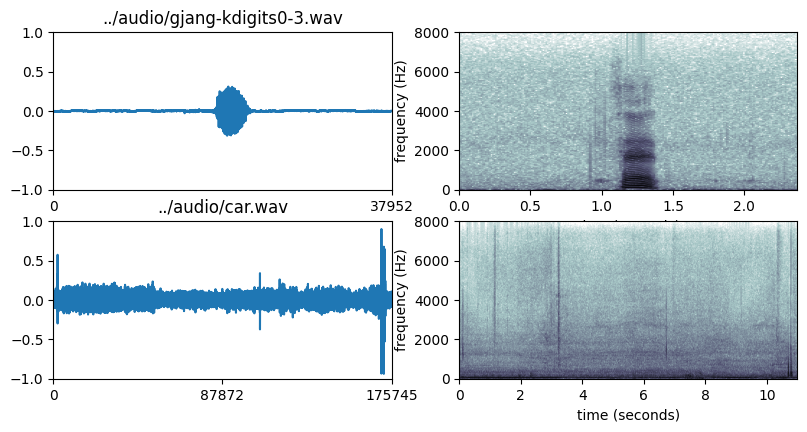

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.2,1.5]))
plt.subplot(2,2,1)
plt.plot(speech); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
plt.title(speechfile)
plt.subplot(2,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)
plt.subplot(2,2,3)
plt.plot(noise); plt.xlim(0,len(noise)); plt.ylim(-1,1); plt.xticks([0, len(noise)//2, len(noise)])
plt.title(noisefile)
plt.subplot(2,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.

__noise gain adjustment to match the targer SNR__

1. 음성과 잡음의 상대적 크기는 SNR (signal-to-noise ratio)로 정의할 수 있다.
$$ SNR = 20 \log_{10} \frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2}[t]}} 
= 10 \log_{10} \frac{\sum_{t=1}^{T} s^2[t]}{\sum_{t=1}^{T} n^{2}[t]} 
= 10 \log_{10} \frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} }
$$
> integer index $t$ 는 sample index, $\langle \cdot \rangle_{T}$ 은 $T$개의 sample mean 을 나타낸다.
2. speech 와 noise 를 다음과 같이 normalize 한다.
$$ \sigma_{s} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} s^{2} [t] } , \quad s_{\sigma = 1} [t] = \frac{s[t]}{\sigma_{s}} , 
\quad \sigma_{n} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2} [t] } , \quad n_{\sigma = 1} [t] = \frac{n[t]}{\sigma_{n}}$$
3. target SNR $r$ 에 맞추기 위한 gain 계산
$$ SNR_{\sigma=1} = 10 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 10 \log_{10} \frac{1}{1} = 0 $$
$$ \Rightarrow r = r + SNR_{\sigma=1} 
= 10 \log_{10} 10^{r/10} + 10 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
$$
$$ = 10 \log_{10} 10^{r/10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
= 10 \log_{10} 10^{r/10} \cdot \left\{ \frac{1/\sigma_{s}}{1/\sigma_{n}} \right\}^2
\frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} } $$
$$ = 10 \log_{10} 10^{-r/10} \left\{ \frac{\sigma_{s}}{\sigma_{n}} \right\}^2
\langle n^2 \rangle_{T} +  10 \log_{10} \langle s^2 \rangle_{T} $$
- 따라서 다음의 치환에 의해 target SNR $r$ 에 맞출 수 있다.
$$ n[t] \Leftarrow \sqrt{10^{-r/10}} \frac{\sigma_{s}}{\sigma_{n}} n[t] = 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00


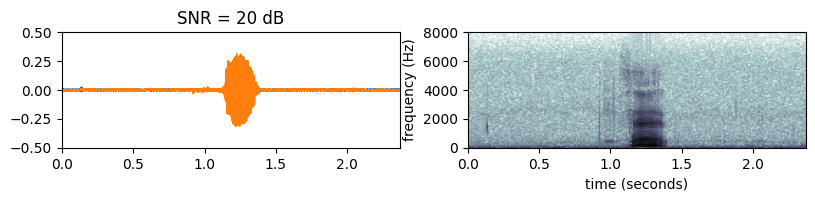

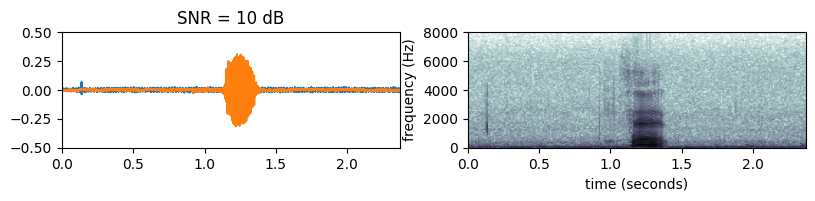

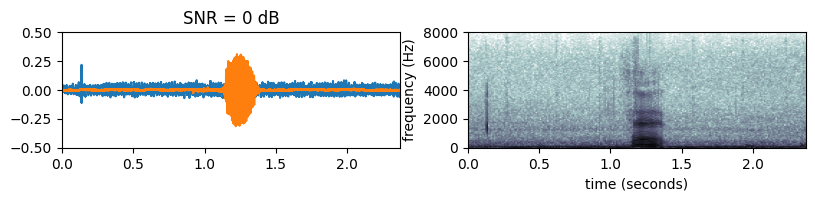

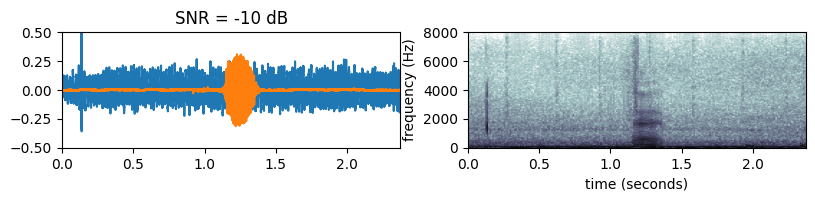

In [9]:
import gjwavfile as wav

std_s = np.sqrt(np.mean(speech**2))
std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
mixsnrs = np.array([20, 10, 0, -10])
mixedSig = []
mixedWavfiles = []
for snr in mixsnrs:
    #gain = np.sqrt(np.power(10, -snr/10))
    gain = np.power(10, -snr/20)
    gn = noise[:len(speech)]/std_n*std_s*gain
    m = speech + gn
    mixedSig.append(m)
    print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))
    
    # draw
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
    plt.subplot(1,2,1)
    xscale = np.arange(len(gn))/Fs
    plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
    plt.title('SNR = %.0f dB' % (snr))
    plt.subplot(1,2,2)
    drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)
    
    # save the mixed file
    fname = addpath(outpath, 'mix%.fdb.wav' % (snr))
    wav.writewav(fname, Fs, m, maxval=1.0)
    mixedWavfiles.append(fname)

In [10]:
IPython.display.Audio(mixedWavfiles[0])

In [11]:
IPython.display.Audio(mixedWavfiles[1])

In [12]:
IPython.display.Audio(mixedWavfiles[2])

In [13]:
IPython.display.Audio(mixedWavfiles[3])

- 입력 음성 파일에 무음구간이 워낙 많기 때문에 음성이 상대적으로 크게 들린다. 원래 0 dB 에서는 크기가 거의 같아야 한다.
- 제대로 SNR 을 측정하기 위해서는 음성과 잡음의 무음 구간을 고려해야 한다.

Target SNR = -5 dB, gain = 1.78, Mixing SNR (whole interval) =-13.82


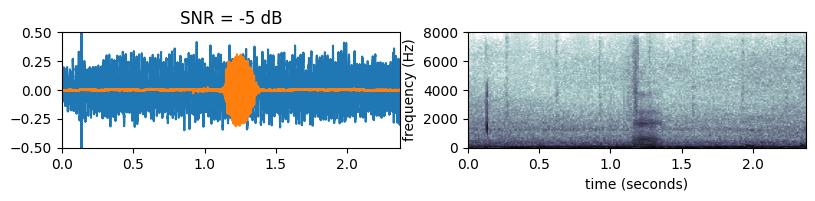

In [14]:
# 음성 존재구간을 tight 하게 잡고(1.1-1.4 sec) SNR = -5 dB 로 합성
tightinterval = (np.array([1.1, 1.4])*Fs).astype(int)
ss = speech[tightinterval[0]:tightinterval[1]]
nn = noise[tightinterval[0]:tightinterval[1]]
std_s = np.sqrt(np.mean(ss**2))
std_n = np.sqrt(np.mean(nn**2))
snr = -5
gain = np.sqrt(np.power(10, -snr/10))
gn = noise[:len(speech)]/std_n*std_s*gain
m = speech + gn
print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR (whole interval) =%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))

# draw
plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
xscale = np.arange(len(gn))/Fs
plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
plt.title('SNR = %.0f dB' % (snr))
plt.subplot(1,2,2)
_ = drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

# save the mixed file
fname = addpath(outpath, 'mixtight%.fdb.wav' % (snr))
wav.writewav(fname, Fs, m, maxval=1.0)
mixedWavfiles.append(fname)

In [15]:
IPython.display.Audio(mixedWavfiles[-1])

---
## Programming assignments: spectral subtraction and Wiener filtering, end point detectoin

1. 각각의 SNR에 대해서 잡음을 앞의 0.5 초 구간에서 추정하고 이를 차감하는 FIR 필터를 적용하여 잡음을 제거한다.
2. energy 기반 end point detectoin 을 구현한다. 
3. end point detection 으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.

---
## Solution

![FIR filtering with memory](figures/lab04_fig1.png)

### Wiener Filter for speech enhancement
- Based on 
    1. [Lecture Notes on Wiener Filtering](http://www.eie.polyu.edu.hk/~mwmak/papers/WienerFilter.pdf), [Man-Wai MAK, The Hong Kong Polytechnic University](http://www.eie.polyu.edu.hk/~mwmak/mypubl.htm)
    2. [Chapter 11 Wiener Filtering](https://ocw.mit.edu/courses/6-011-introduction-to-communication-control-and-signal-processing-spring-2010/resources/mit6_011s10_chap11/), [MIT OpenCourseware, Spring 2010, Introduction to Communication, Control, and Signal Processing](https://ocw.mit.edu/courses/6-011-introduction-to-communication-control-and-signal-processing-spring-2010/)

**Notation Shift (in accordance with MAK's notation)**
- $x(t), x[t], X(\omega)$: unobservable clean speech signal in continuous/discrete time and frequency domain
    > $s(t), S(\omega)$ 는 아래에서 사용하는 correlation 의 Fourier transform 과 겹친다.
    
    > 엄밀히 정의하면 $t$는 continuous time 을 의미하지만 $x[t]$ 로 쓰면 $t$가 discrete index 라고 가정한다($n$ 을 쓰면 noise 와 겹침).
- $y(t), y[t], Y(\omega)$: noisy, observated signal
- $n(t), n[t], N(\omega)$: underlying noise signal 
- $X(k, \omega)$, $Y(k, \omega)$, $N(k, \omega)$: frame $k$ 의 주파수 $\omega$ 성분

**Wiener filter derivation**
1. (_optimal Wiener filter assumption_) unknown source $x(t)$, noisy observation $y(t)$ 가 있을 때, 다음과 같이 linear filter $h(t)$ 로 추정할 수 있다고 가정하자($H(z)$ in $z-$domain).
$$ \hat{x}(t) = h(t) \ast y(t) = \sum_{\tau=0}^{M-1} h(\tau) y(t-\tau) $$
3. estimation error 는 $y(t)$ 와 uncorrelated by the theorem of orthogonality, correlation 은 0
$$ e(t) = \hat{x}(t) - x(t) , \quad e(t) \perp y(t) \Leftrightarrow E_{t} [e(t) y(t-m)] = 0 , \forall m \in \mathcal{R} $$
4. compute cross-correlation signal of $\hat{x}$ and $y$ with shift $m$:
$$ R_{\hat{x} y} (m) = E_{t}[ \hat{x}(t) y(t-m) ] = E_{t}[ ( x(t)-e(t) ) y(t-m) ] = E_{t} [ x(t) y(t-m) ] = R_{x y} (m) $$
5. equivalently, using $h(t) \ast y(t)$,
$$ R_{\hat{x} y} (m) = E_{t}[ h(t) \ast y(t) \cdot y(t-m) ] = E_{t}[ \sum_{\tau=0}^{M-1} h(\tau) y(t-\tau) \cdot y(t-m) ] $$ 
$$ = \sum_{\tau=0}^{M-1} h(\tau) E_{t}[ y(t-\tau) y(t-m) ] 
= \sum_{\tau=0}^{M-1} h(\tau) R_{yy} (m)
= h(m) \ast R_{yy} (m) $$
6. 즉 $R_{x y} (m) = h(m) \ast R_{yy} (m) $ 이다. 양변을 Fourier transform 하면 
$$R_{x y} (m) = h(m) \ast R_{yy} (m) \quad  \Leftrightarrow \quad S_{x y} (\omega) = H(\omega) S_{yy} (\omega) $$
$$\Leftrightarrow \quad H(\omega) = \frac{S_{xy} (\omega)}{S_{yy} (\omega)} $$

**Wiener filter for speech enhancement**
1. assumption of additive noise model 
$$ y(t) = x(t) + n(t) $$
      - $y(t)$ 만 주어지고 $x(t)$, $n(t)$ 는 모른다 (구해야 한다)
      - $x(t)$ 와 $n(t)$ 는 uncorrelated ($x(t) \perp n(t) \Leftrightarrow R_{xn}(\cdot) = 0$), 서로 관계없는 신호이기 때문.
2. $x(t)$ 를 다음과 같이 optimal Wiener filter $H(z)$, 또는 $h(n)$ 으로 추정할 수 있다고 가정하자.
$$ x(t) = y(t) - n(t) \quad \Rightarrow \quad \hat{x}(t) = h(t) \ast y(t) = \sum_{\tau=0}^{M-1} h(\tau) y(t-\tau) $$
3. optimal Wiener filter를 구하기 위해서는 $R_{yy}$, $R_{xy}$ 가 필요하다.
$$ R_{y y} (m) \quad = \quad E_{t}[ y(t) y(t-m) ] = E_{t}[ ( x(t)+n(t) ) ( x(t-m)+n(t-m) ) ] $$
$$ = E_{t} [ x(t) x(t-m) + 0 + n(t) n(t-m)] $$
$$ = R_{xx} (m) + R_{nn} (m)$$
$$ R_{x y} (m) \quad = \quad E_{t}[ x(t) y(t-m) ] = E_{t}[ x(t) ( x(t-m)+n(t-m) ) ] $$
$$ = E_{t} [ x(t) x(t-m)] + E_{t}[x(t) n(t-m)] = E_{t} [ x(t) x(t-m)] $$
$$= R_{xx} (m) $$

6. 즉 $R_{x y} (m) = h(m) \ast R_{yy} (m) $ 에 대입하고 양변을 Fourier transform 하면 
$$R_{x x} (m) = h(m) \ast (R_{xx} (m)+R_{nn}(m)) \quad \Leftrightarrow \quad H(\omega) = \frac{S_{xx} (\omega)}{S_{xx} (\omega) + S_{nn} (\omega)} $$

7. (_original implementation_) $x \leftarrow \hat{x}$, $H(\omega)$를 적당한 값에서 시작하여 recursive 하게 추정
$$H(\omega) = \frac{S_{\hat{x} \hat{x}} (\omega)}{S_{\hat{x} \hat{x}} (\omega) + S_{nn} (\omega)} $$

**Practical implementation**
1. time reversal in time domain $\rightarrow$ complex conjugate (켤레 복소수) in the frequency domain
$$ x[-t] \Rightarrow X(z^{-1}), \, X(e^{-j\omega}) = X^{\ast} (e^{j \omega})$$
$$R_{xy}(m) = E_{t} \left[ x(t) y(t-m) \right] = \frac{1}{N_f} \left[ x(t) \ast y(-(m-t)) \right] 
\quad \Rightarrow \quad S_{xy} (\omega) = X(\omega) Y^{\ast}(\omega)$$

    - Autocorrelation 의 정의에서 expectation 을 계산하기 위해 $\frac{1}{N_{f}}$ 를 곱해줘야 하지만 
      어차피 모든 expectation 에 공통인 상수라 $X(\omega)$ 와 $Y(\omega)$ 에 적지 않았다.

2. $S_{xx} (\omega) \simeq X (\omega) X^{\ast} (\omega) = |X (\omega)|^2 $, 
$S_{nn} (\omega) \simeq  N (\omega) N^{\ast} (\omega) = |N (\omega)|^2$. 즉, power spectral density 로 추정 가능 

    - 직관적으로 생각해 보면 autocorrelation 함수는 0에 대해서 symmetric 하다. 따라서 이 함수의 Fourier transform 의 
      허수 성분은 anti-symmetric 한 sine 함수가 곱해져서 0이 된다. 
    
    - 왜 $S_{xx}(\omega) \geq 0$? - 아마 실수성분인 sine 함수로 전개하면 증명이 가능할 듯.
    
    - $x$는 unknown, 그래서 observation $y$ 와 추정된 noise $n$ 으로 추정한다.

$$H(\omega) = \frac{S_{xx} (\omega)}{S_{xx} (\omega) + S_{nn} (\omega)} \simeq 
  \frac{|X(\omega)|^2}{|X(\omega)|^2 + |N(\omega)|^2} \simeq \frac{|Y(\omega)|^2 - |N(\omega)|^2}{|Y(\omega)|^2} $$

3. 유한한 값들로 PSD 를 근사하기 때문에 $|Y|^2-|N|^2 < 0$ 경우를 고려해야 함. Wiener filter 계수를 $[\varepsilon , 1]$ 으로 보장시키고 frame 별로 계수를 구한다.
    - assume that noise is fixed over time, and find $H(k, \omega)$ for frame $k$
$$H(k, \omega) \triangleq \max\left\{ \varepsilon,  \frac{|Y(k, \omega)|^2 - |\tilde{N}(\omega)|^2}{|Y(k, \omega)|^2} \right\}$$
    - minimum Wiener filter gain $\varepsilon$ 은 EVRC (enhanced variable rate coding), 
      ETSI (European standard telecommunication institute) 의 
      표준 noise suppression module 에는 -13 dB ($\approx 0.224$)를 사용하고 있다. 
    - 그렇지만 -20 dB (0.1) 정도까지는 듣기 거북할 정도로 왜곡이 심하게 발생하진 않는다. 다만 음성인식기는 왜곡에 민감하므로 -13 dB 가 적당하다.

### Noise spectrum estimation in a fixed interval
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 일정 시간은 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정
    - 아래 예제는 $0 \sim 0.5$ sec

In [16]:
####################################
def __sumSpect(x, I):
    #plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
    #plt.plot(x[I[0]:I[1]])
    Nt = I[1]-I[0]
    nframes = int((Nt-Nf)//Ns+1)
    Sxx = np.zeros(hNo)   # E[N*conj(N)]
    for n in range(nframes):
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 = (X*np.conj(X))
        Sxx += aX2[:hNo].real
        
    return Sxx, nframes

####################################
def estSpect(x, IntervalMulti=[]):
    # x: 1-dim time domain signal
    # IntervalMulti:  
    #   2-dim matrix, [n_interval, 2]: multiple intervals
    #   empty list: use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0, len(x)]])
    #print(IntervalMulti, IntervalMulti.shape)
    
    # accumulate interval power spectral densities
    SxxSum = np.zeros(hNo)   # E[N*conj(N)]
    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Sxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        SxxSum = SxxSum + Sxx
        NumFrames += N
        
    # average (E[x*conj(x)]
    return SxxSum/NumFrames

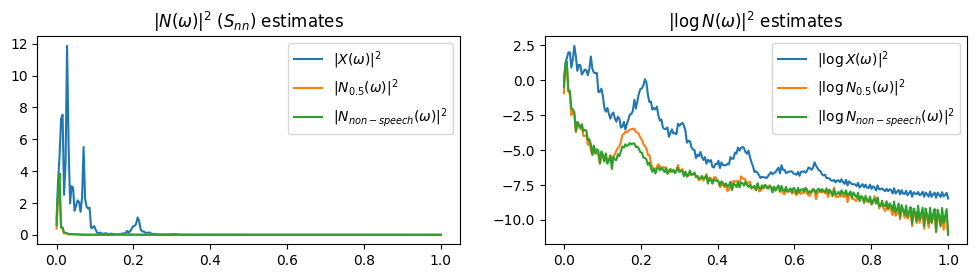

In [17]:
####################################
mix = mixedSig[1]
SyyAll = estSpect(mix, [])
#SyyEPD = estSpect(mix, np.array([[1.1, 1.4]])*Fs)
#SxxEPD = estSpect(speech, np.array([[1.1, 1.4]])*Fs)
SnnHead = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
SnnEPD = estSpect(mix, np.array([[0,1.0], [1.5, 2.0], [2.0, 2.2]])*Fs)

####################################
# plot
plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
xticks=np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,SyyAll,label='$|X(\omega)|^2$')
plt.plot(xticks,SnnHead,label='$|N_{0.5}(\omega)|^2$')
plt.plot(xticks,SnnEPD,label='$|N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,SxxEPD,label='$|S(\omega)|^2$')
plt.title('$|N(\omega)|^2$ ($S_{nn}$) estimates')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(xticks,np.log(SyyAll),label='$|\log X(\omega)|^2$')
plt.plot(xticks,np.log(SnnHead),label='$|\log N_{0.5}(\omega)|^2$')
plt.plot(xticks,np.log(SnnEPD),label='$|\log N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,np.log(SxxEPD),label='$|\log S(\omega)|^2$')
plt.title('$|\log N(\omega)|^2$ estimates')
plt.legend(loc='upper right')

- 0.5초로 추정한 $|N(\omega)|^2$ 이 전체 non-speech 구간에 매우 유사함을 알 수 있다.
- Wiener filter 를 time domain FIR filter 로 구하고 적용한다. 
  아래 코드는 online processing 을 염두에 두고 한 shift (10ms) 처리하는 방식으로 구현되었다.
- plot Wiener filters

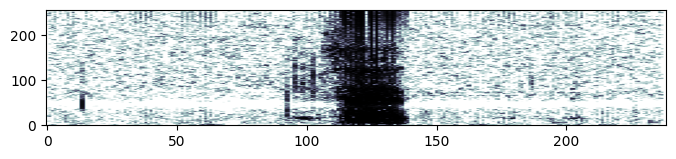

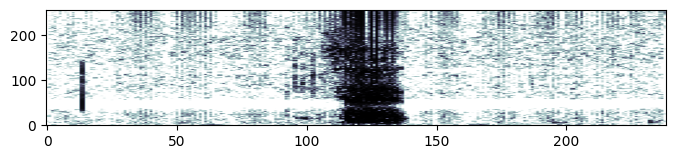

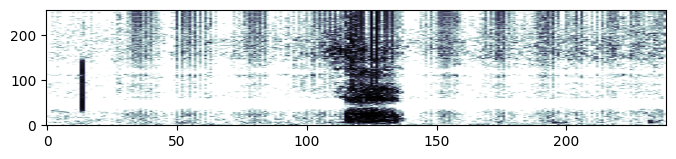

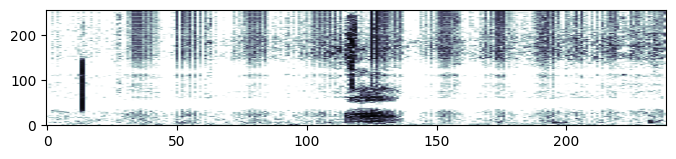

In [18]:
order = 30
noverlap = int(Fs*0.003)   # 3ms
Nx = len(mix)

#minwfgain = 10**(-13/20)    # 0.228
minwfgain = 10**(-20/20)    # 0.1

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)

# overlap add 를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest = []
for mix in mixedSig:
    Snn = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
    
    Tx = len(mix)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0  # time index
    H_a = np.zeros((hNo,0))   # for drawing
    while True:
        t1 = min(t,Nx)      # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns,Nx)   # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함
        
        for ii in range(Nf-Ns):
            xbuf[ii] = xbuf[ii+Ns]
        xbuf[(Nf-Ns):] = 0
        for ii in range(t2-t1):
            xbuf[(Nf-Ns)+ii] = mix[t1+ii]
        X = np.fft.fft(xbuf, NFFT)
        aX2 = (X*np.conj(X))
        Syy = aX2[:hNo].real
        Syy = np.maximum(1e-100, Syy)  # to prevent divide by zero
        H = (Syy-Snn)/Syy
        H = np.maximum(minwfgain, H)
        '''
        if t<Ns*10:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.9]))
            #plt.plot(H)
            plt.plot(Syy)
            plt.plot(Snn)
            plt.plot(Syy-Snn)
        '''
        H_a = np.column_stack([H_a, np.expand_dims(H,axis=1)])

        h, _ = getLPHFIRFFT(H, order, winname='hamming')
        x = mix[t1:t2]
        y, l = fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout            
        if l <= 0: break
        
        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns
        
    speechest.append(yout)
    plt.figure(figsize=FIG_SIZE*np.array([1.0,0.5]))
    plt.imshow(H_a, cmap=cmap_plot, aspect='auto', origin='lower')    

- save noise suppresion results in files
- compare before and after by SNR
    > linear phase Wiener filter with overlap-add 를 하면 order + overlap 만큼의 delay 가 발생한다. 
    > noise suppressed signal 을 shift 하여 SNR 을 계산한다.

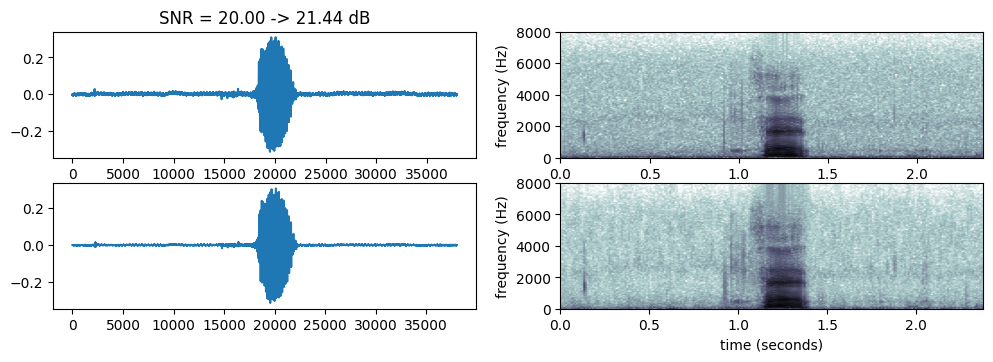

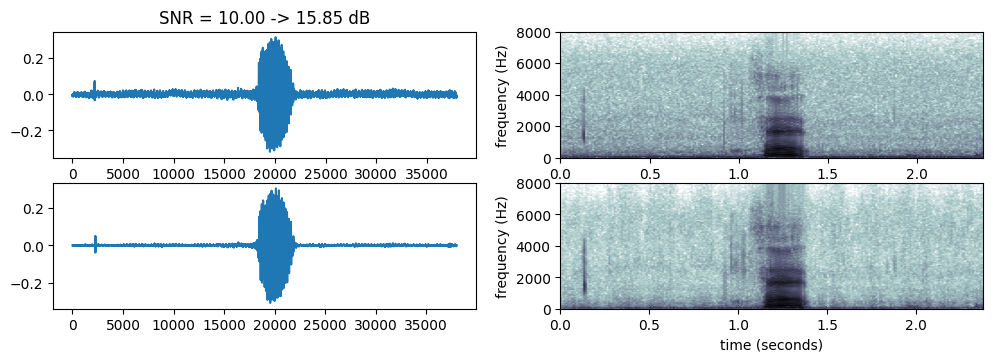

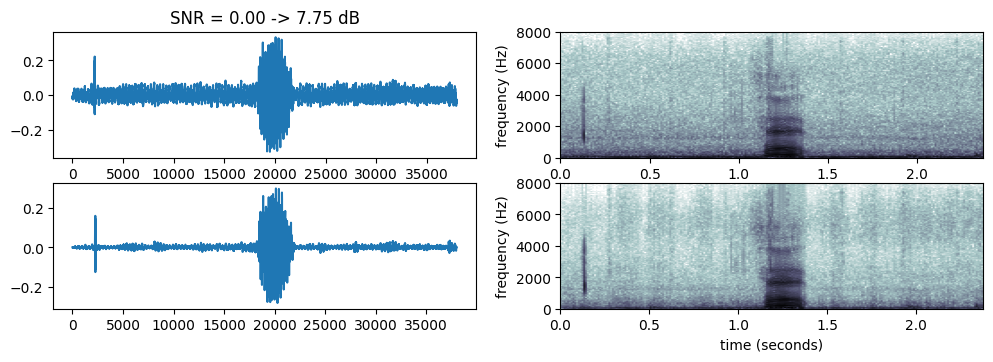

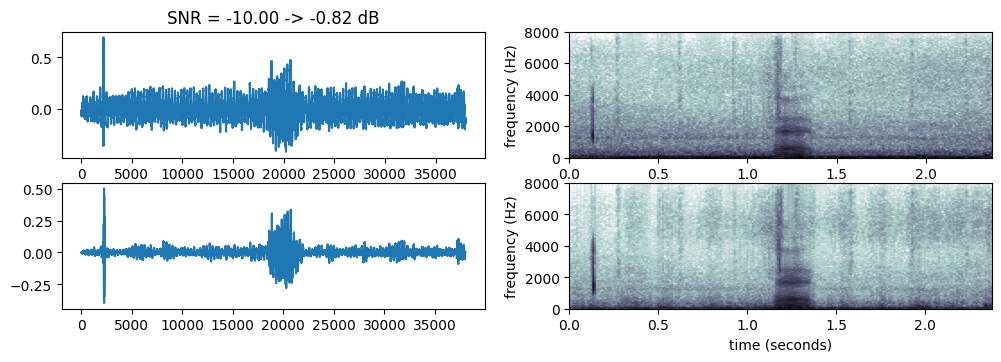

In [19]:
def getsnr(target, est):
    diff = np.sum((target-est)**2)
    diff = max(diff, 1e-30)   # to prevent divide by zero
    return 10*(np.log10(np.sum(target**2))-np.log10(diff))

nsWavfiles = []
for m in range(len(mixedSig)):
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.2]))
    plt.subplot(2,2,1)
    plt.plot(mixedSig[m])
    #plt.title('SNR = %.2f -> .2f dB' % (mixsnrs[m]))
    snrmix = getsnr(speech, mixedSig[m])
    snrest = getsnr(speech, speechest[m][fola.getDelay():])
    plt.title('SNR = %.2f -> %.2f dB' % (snrmix, snrest))
    plt.subplot(2,2,2)
    drawspectrogram3(mixedSig[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    plt.subplot(2,2,3)
    plt.plot(speechest[m])
    plt.subplot(2,2,4)
    drawspectrogram3(speechest[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    
    # save the noise suppressed audio file
    fname = addpath(outpath, 'ns%.fdb.wav' % (mixsnrs[m]))
    wav.writewav(fname, Fs, speechest[m], maxval=1.0)
    nsWavfiles.append(fname)

- SNR imporvement 가 만족스럽진 않다. 이 예제가 저음이 강해서 대부분 잡음이 영향을 많이 주진 못한다.
- -10 dB 의 경우 음성의 왜곡이 많이 발생한다.
- mixed sound 와 noise suppressed sound 를 들어보자

In [20]:
IPython.display.Audio(mixedWavfiles[0])

In [21]:
IPython.display.Audio(nsWavfiles[0])

In [22]:
IPython.display.Audio(mixedWavfiles[1])

In [23]:
IPython.display.Audio(nsWavfiles[1])

In [24]:
IPython.display.Audio(mixedWavfiles[2])

In [25]:
IPython.display.Audio(nsWavfiles[2])

In [26]:
IPython.display.Audio(mixedWavfiles[3])

In [27]:
IPython.display.Audio(nsWavfiles[3])

.

### Noise spectrum estimation with EPD (end point detection)
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 일정 시간은 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정
    - 아래 예제는 $0 \sim 0.5$ sec

.

## End of Lab 04